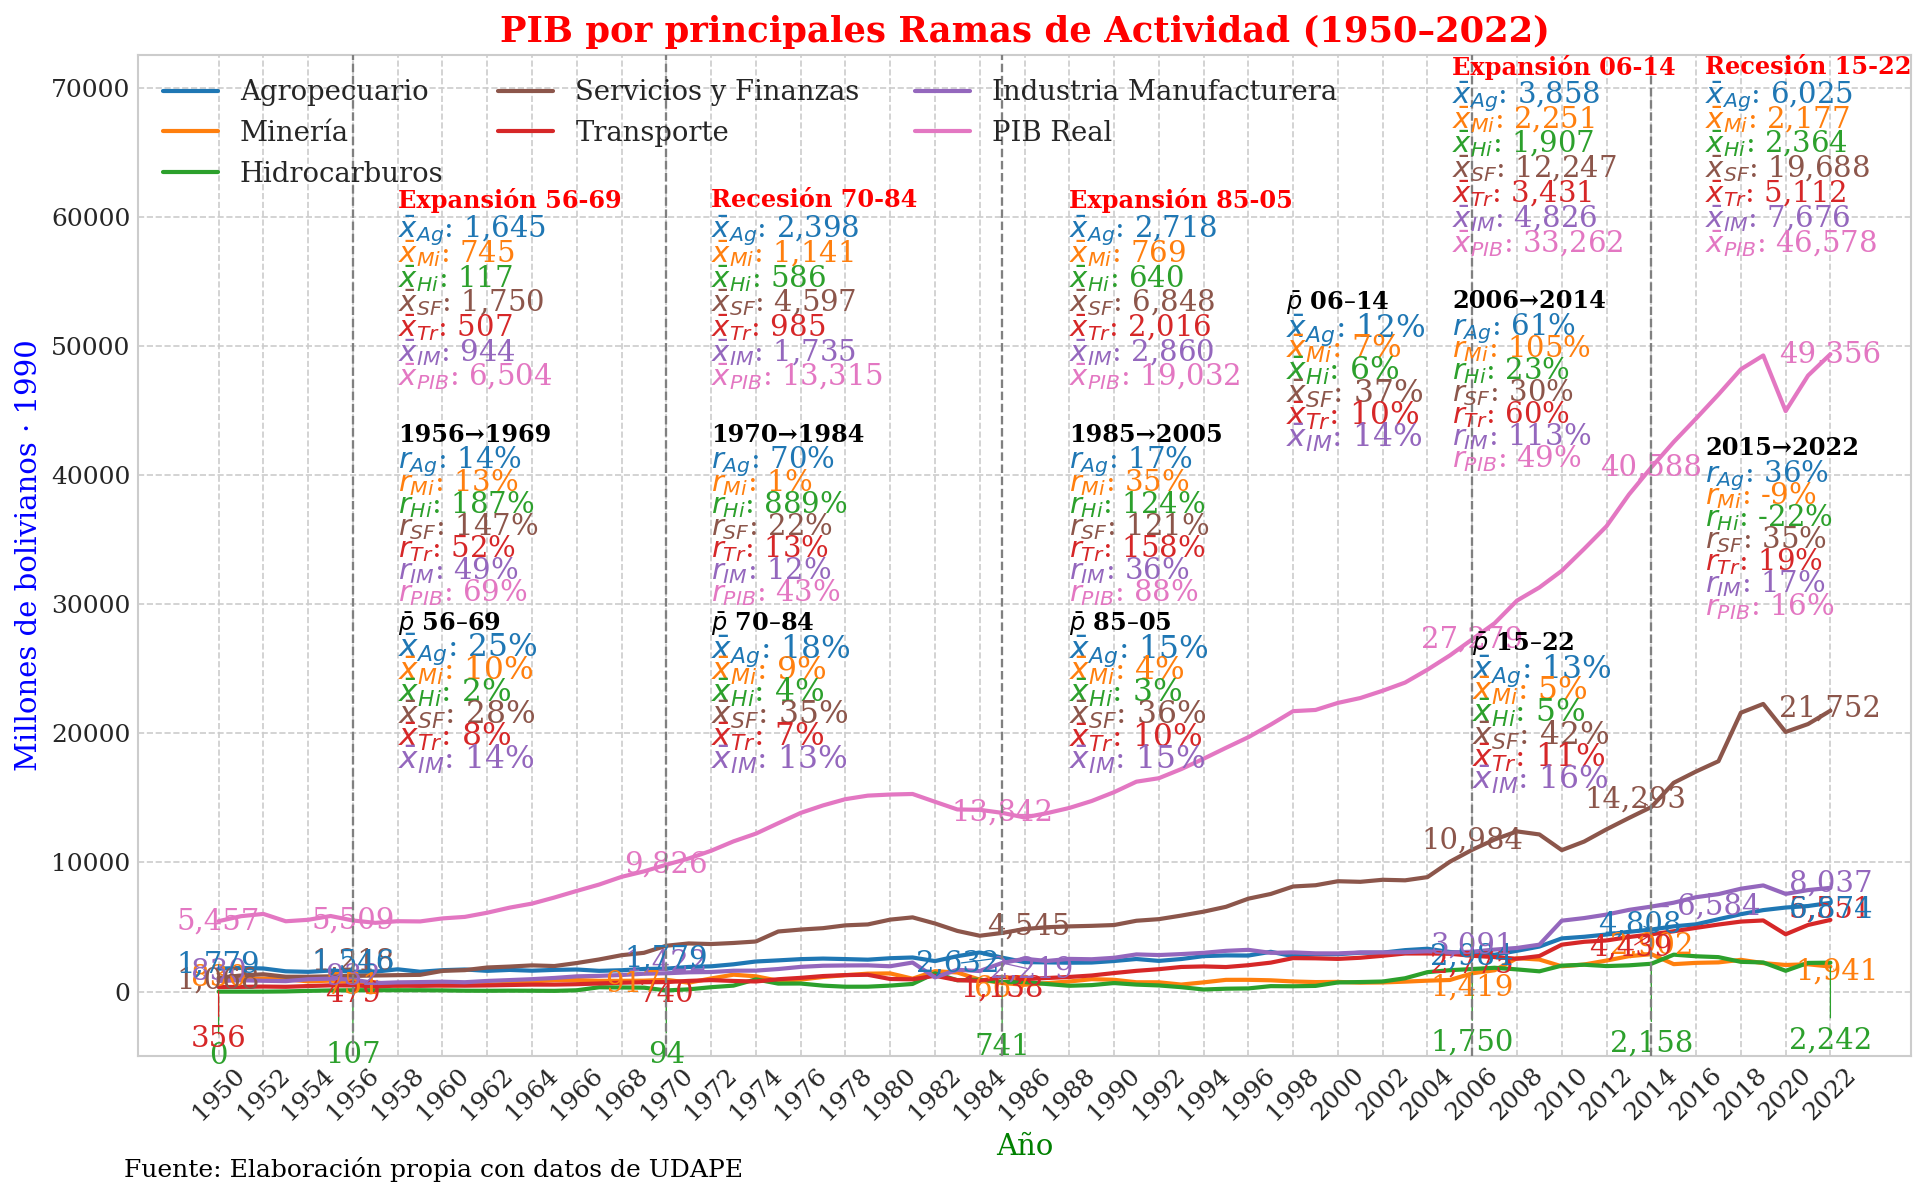

In [1]:
# ── Imports ──────────────────────────────────────────────────────────
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3, os, sys
sys.path.append(os.path.abspath('../'))
from func_auxiliares.graficos_utils import *
from func_auxiliares.config import *

# ── Configuración general ────────────────────────────────────────────
# Dirección
output_dir = "../../../../assets/tesis/serie_completa/pib"
os.makedirs(output_dir, exist_ok=True)

# Estilos
set_style()

# Carga de datos
with sqlite3.connect('../../../../db/proyectomacro.db') as conn:
    df = (pd.read_sql('SELECT * FROM pib_ramas', conn, index_col='año')
            .sort_index()) / 1000        # miles → millones
df["servicios_y_finanzas"]=df["comercio_finanzas"] +df["servicios"] +df["derechos_imp"]+df["propiedad_vivienda"]
df.drop(columns=["comercio_finanzas", "servicios", "derechos_imp", "propiedad_vivienda"], inplace=True)
# Sectores y columnas
componentes = [
    ("agropecuario",      "Agropecuario"),
    ("mineria",           "Minería"),
    ("petroleo",          "Hidrocarburos"),
    ("servicios_y_finanzas", "Servicios y Finanzas"),
    ("transportes", "Transporte"),
    ("industria_manufacturera", "Industria Manufacturera"),
    ("pib_real", "PIB Real"),
]
cols_componentes = [col for col, _ in componentes]

# Abreviaturas
abbr = {
    "agropecuario":      "Ag",
    "mineria":           "Mi",
    "petroleo":          "Hi",
    "servicios_y_finanzas": "SF",
    "transportes":    "Tr",
    "industria_manufacturera": "IM",
    "pib_real": "PIB",
}

# ── Preparación ──────────────────────────────────────────────────────
annot_years=adjust_annot_years(df,annot_years_sin_crisis)
# Ciclos y estadísticas
CYCLES_SIN_CRISIS = adjust_cycles(df, CYCLES_SIN_CRISIS)
cycle_stats_sin_crisis = {
    name: df.loc[period, cols_componentes].mean().to_dict()
    for name, period in CYCLES_SIN_CRISIS.items()
}
periodos_sin_crisis=adjust_periods(df,periodos_tasas_sin_crisis)
# Colores personalizados
custom_colors = {
    "agropecuario":      "#1f77b4",  # blue
    "mineria":           "#ff7f0e",  # orange
    "petroleo":          "#2ca02c",  # green
    "servicios_y_finanzas": "#8c564b",  # café
    "transportes":    "#d62728",  # rojo
    "industria_manufacturera": "#9467bd",  # morado
    "pib_real": "#e377c2",  # rosa
}

# ── Offsets ──────────────────────────────────────────────────────────
annotation_offsets = {
    "agropecuario": {
        1950: (0, 300),1956:(0,700), 1970: (0, 770), 1985: (-2, -450),
        2006: (0, -300), 2014: (-0.5, 370), 2022: (0, -500)
    },
    "mineria": {
        1950: (0, 200),1956:(0,-350), 1970: (-1.5, -350), 1985: (0, -480),
        2006: (0, -1100), 2014: (0, 650), 2022: (0.3, -400)
    },
    "petroleo": {
        1950: (0, -5000),1956:(0,-5000), 1970: (0, -5000), 1985: (0, -5000),
        2006: (0, -5700), 2014: (0, -6200), 2022: (0, -6000)
    },
    "servicios_y_finanzas": {
        1950: (0, -250),1956:(0,1100), 1971: (0, 1100), 1985: (1.2, 500),
        2006: (0, 700), 2014: (-0.7, 600), 2022: (0, 200)
    },
    "transportes": {
        1950: (0, -4000),1956:(0,-700), 1970: (0, -900), 1985: (0, -900),
        2006: (0, -700), 2014: (-0.9, -1000), 2022: (0, 800)
    },
    "industria_manufacturera": {
        1950: (0, 700),1956:(0,200), 1970: (0, 800), 1985: (1.3, -500),
        2006: (0, 500), 2014: (3, 0), 2022: (0, 300)
    },
    "pib_real": {
        1950: (0, 0), 1956: (0, 0), 1970: (0, 0), 1985: (0, 0),
        2006: (0, 0), 2014: (0, 0), 2022: (0, 0)
    }
}

hitos_offset = {1950: 0.45, 1971: 0.50, 1985: 0.50, 2005: 0.62, 2015: 0.48}

medias_offsets = {
    "Expansión 56-69": (1958, 1.2),
    "Recesión 70-84":  (1972, 1.2),
    "Expansión 85-05": (1988, 1.2),
    "Expansión 06-14": (2005.1, 1.4),
    "Recesión 15-22":  (2016.4, 1.4),
}

period_offsets = {
    "1956-1969": (1958, 0.85),
    "1970-1984": (1972, 0.85),
    "1985-2005": (1988, 0.85),
    "2006-2014": (2005.1, 1.05),
    "2015-2022": (2016.4, 0.83),
}

participation_offsets = {
    "1956-1969": (1958, 0.57),
    "1970-1984": (1972, 0.57),
    "1985-2005": (1988, 0.57),
    "2006-2014": (1997.7, 1.05),
    "2015-2022": (2006, 0.54),
}

# ── Gráfica ──────────────────────────────────────────────────────────
fig, ax=init_base_plot(
    df=df,
    series=componentes,
    colors=custom_colors,
    title=f"PIB por principales Ramas de Actividad ({df.index[0]}–{df.index[-1]})",
    xlabel="Año",
    ylabel="Millones de bolivianos · 1990",
    source_text="Fuente: Elaboración propia con datos de UDAPE"
)

# Hitos verticales
add_hitos(ax, df.index, hitos_v_sin_crisis, hitos_offset)

# Anotaciones de valores por año
add_year_value_annotations(
    ax, df, annot_years,
    cols_componentes, annotation_offsets, custom_colors, arrow_lw=0.6
)

# Cuadros de medias por ciclo
y_max = ax.get_ylim()[1]
line_spacing = y_max * 0.037
add_cycle_means_multi(
    ax, cycle_stats_sin_crisis, medias_offsets,
    abbr, custom_colors, line_spacing
)



# Anotaciones de tasas de crecimiento por periodo
add_period_growth_annotations_multi(
    ax, df, periodos_sin_crisis, cols_componentes,
    period_offsets, custom_colors, abbr, line_spacing_ratio=0.033
)

# Cuadros de participación por ciclo
add_participation_cycle_boxes(
    ax, df, periodos_sin_crisis, ['agropecuario', 'mineria', 'petroleo', 'servicios_y_finanzas', 'transportes', 'industria_manufacturera'], "pib_real",
    participation_offsets, abbr, custom_colors, line_spacing=0.033
)
ax.set_ylim(-5000, 1.4 * y_max)
plt.savefig(f"{output_dir}/pib_rama_de_actividad.png", dpi=300, bbox_inches='tight')
plt.show() 


In [4]:
df

,agropecuario,minas_canteras_total,mineria,petroleo,industria_manufacturera,construcciones,energia,transportes,gobierno_general,pib_nominal,pib_real,servicios_y_finanzas
año,,,,,,,,,,,,
1950,1779.438682,830.404718,830.404718,1.000000e-08,830.404718,118.629245,118.629245,355.887736,355.887736,5456.945293,5456.945293,1067.663209
1951,1834.743891,954.066823,954.066823,1.000000e-08,880.677068,146.779511,73.389756,366.948778,366.948778,5871.180450,5841.824548,1247.625846
1952,1793.084019,1008.609760,1008.609760,1.000000e-08,840.508134,168.101627,112.067751,392.237129,336.203253,5995.624687,6018.038237,1344.813014
1953,1573.775398,973.469318,957.244830,1.622449e+01,811.224432,129.795909,81.122443,373.163239,356.938750,5451.428184,5448.183286,1151.938694
1954,1532.891837,855.370583,796.087474,5.928311e+01,956.998771,127.035235,84.690157,431.919799,423.450784,5564.143299,5561.602594,1151.786132
...,...,...,...,...,...,...,...,...,...,...,...,...
2018,5995.646000,4768.653000,2462.609000,2.306044e+03,7968.579000,1945.911000,1009.196000,5423.980000,4925.583000,48188.730000,48188.730000,21595.254000
2019,6313.394000,4467.666000,2208.619000,2.259047e+03,8223.078000,1983.155000,1037.757000,5512.248000,5128.989000,49256.933000,49256.933000,22275.742000
2020,6510.914000,3678.571000,2064.013000,1.614558e+03,7566.003000,1605.674000,1001.136000,4440.675000,5249.479000,44952.919000,44952.919000,20105.330000


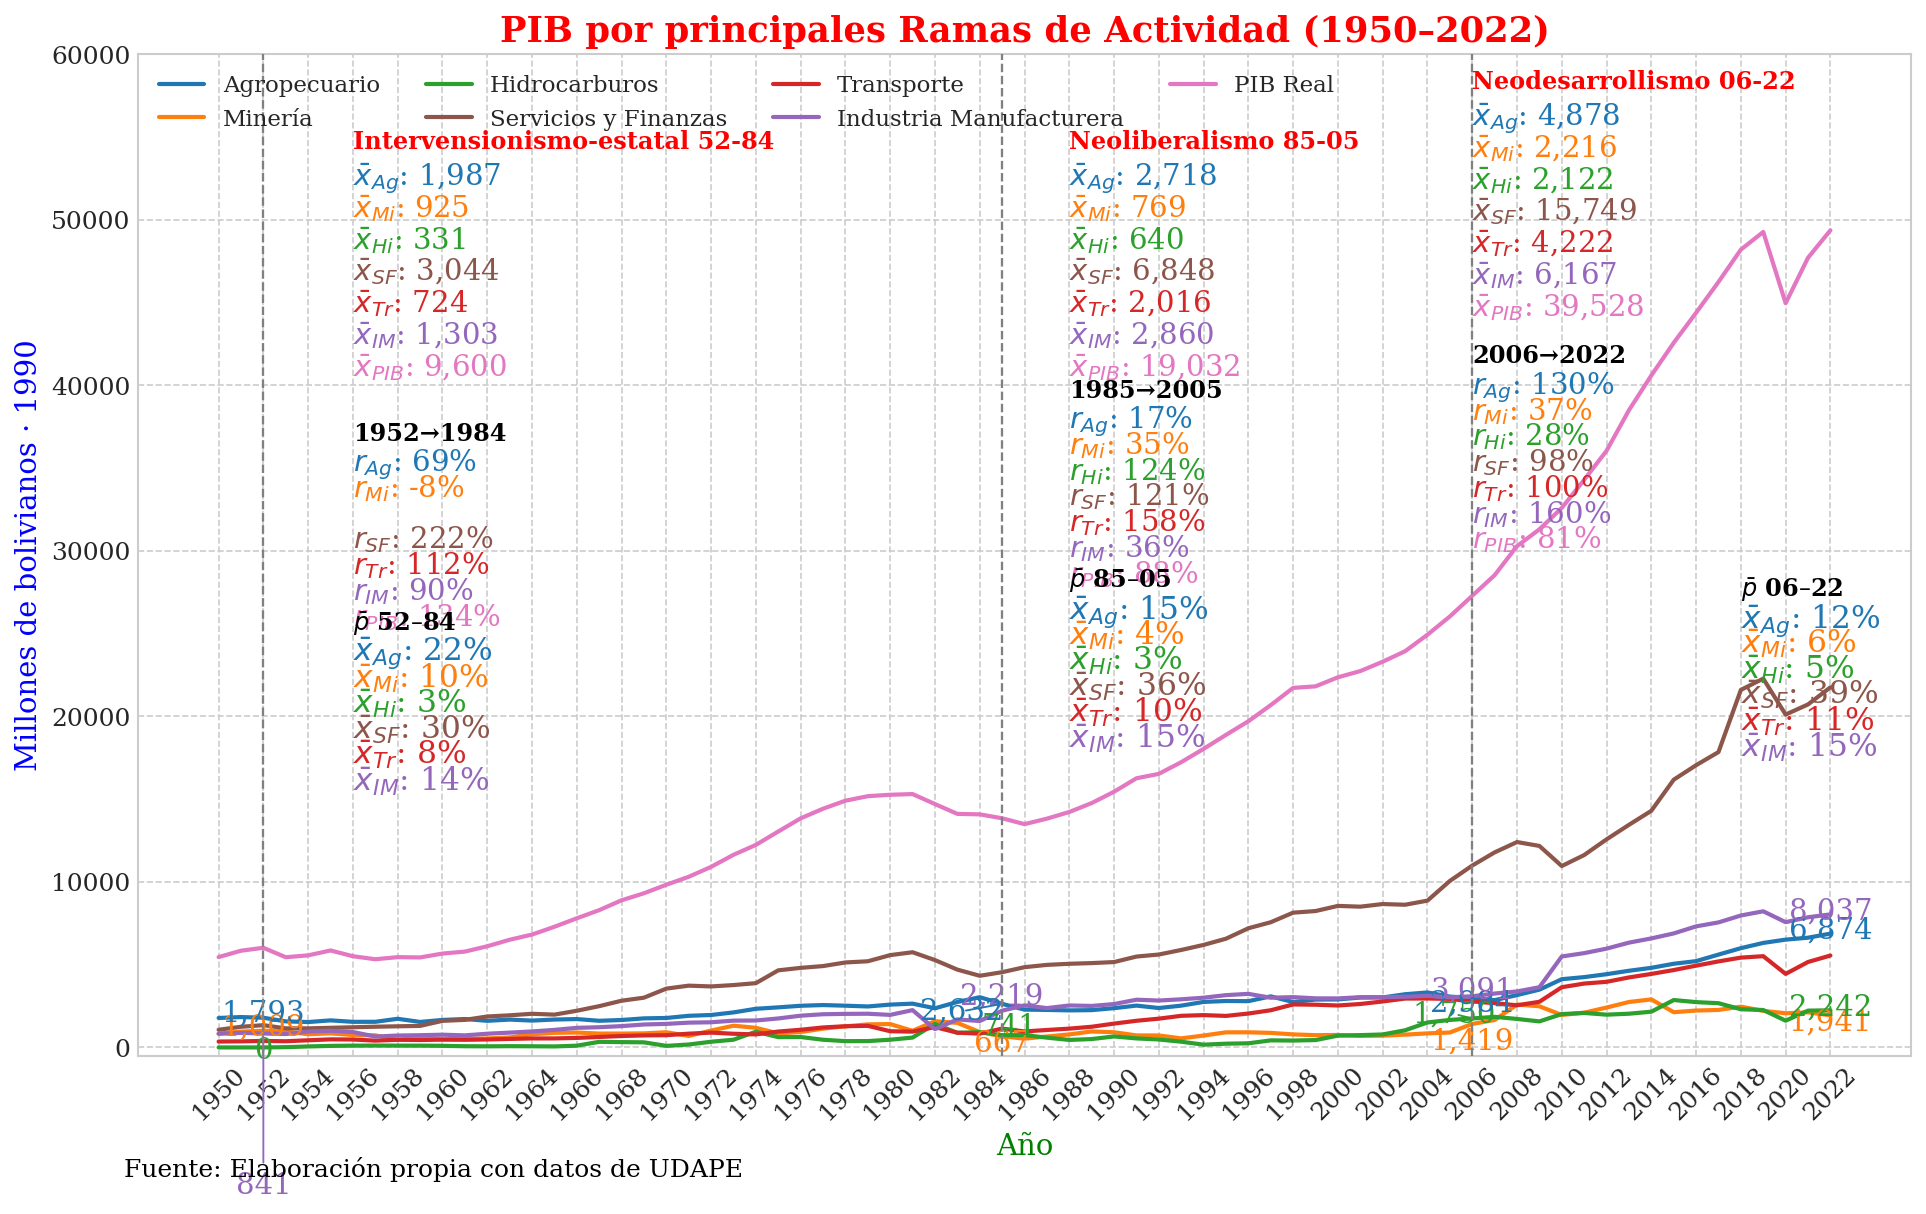

In [2]:
#grafica por periodo
# Estadísticas de ciclos
annot_years_periodos=adjust_annot_years(df,annot_years_periodos)
CYCLES_PERIODOS=adjust_cycles(df,CYCLES_PERIODOS)
cycle_stats_periodos = {
    name: df.loc[period, cols_componentes].mean().to_dict()
    for name, period in CYCLES_PERIODOS.items()
}
periodos_periodos=adjust_periods(df,periodos_tasas_periodos)

# ── Offsets ──────────────────────────────────────────────────────────
# Desplazamientos de anotaciones por rama y año
annotation_offsets = {
    "agropecuario": {
        1952: (0, 300), 1985: (-1.8, -450),
        2006: (0, -300), 2022: (0, 200)
    },
    "mineria": {
        1952: (0, 200), 1985: (0, -420),
        2006: (0, -1050), 2022: (0, -400)
    },
    "petroleo": {
        1952: (0, -200), 1985: (0.3, 550),
        2006: (-0.8, 270), 2022: (0, 200)
    },
    "comercio_finanzas": {
        1952: (0, -250), 1985: (0.3, 900),
        2006: (-0.8, 400), 2022: (0, 200)
    },
    "construcciones": {
        1952: (0, -600), 1985: (0, 300),
        2006: (0, 200), 2022: (0, 760)
    },
    "industria_manufacturera": {
        1952: (0, -9150), 1985: (0, 900),
        2006: (0, 350), 2022: (0, 200)
    }
}

# Hitos verticales (usar los mismos años que hitos_v_periodos)
hitos_offset = {
    1952: 0.45,  # antes era 1950
    1985: 0.50,
    2006: 0.50,
}
# Cuadros de medias por ciclo (claves idénticas a CYCLES_PERIODOS)
medias_offsets = {
    "Intervensionismo-estatal 52-84": (1956, 1.07),  # antes "50-84"
    "Neoliberalismo 85-05":            (1988, 1.07),
    "Neodesarrollismo 06-22":          (2006, 1.14)  # antes "06-22"
}

# Desplazamientos de recuadros de periodo y texto
period_offsets = {
    "1952-1984": (1956, 0.73),  # antes "1950-1984"
    "1985-2005": (1988, 0.78),
    "2006-2022": (2006, 0.82),
}


# Desplazamientos de participación por ciclo
participation_offsets = {
    "1952-1984": (1956, 0.51),  # antes "1950-1984"
    "1985-2005": (1988, 0.56),
    "2006-2022": (2018, 0.55),
}
#grafica 
fig, ax = init_base_plot(
    df=df,
    series=componentes,
    colors=custom_colors,
    title=f"PIB por principales Ramas de Actividad ({df.index[0]}–{df.index[-1]})",
    xlabel="Año",
    ylabel="Millones de bolivianos · 1990",
    source_text="Fuente: Elaboración propia con datos de UDAPE",
    legend_fontsize=11,
    legend_ncol=4
)

# Líneas de hitos y anotaciones
add_hitos(ax, df.index, hitos_v_periodos, hitos_offset)
add_year_value_annotations(
    ax, df, annot_years_periodos, cols_componentes,
    annotation_offsets, custom_colors,arrow_lw=0.9
)

add_cycle_means_multi(
    ax, cycle_stats_periodos, medias_offsets,
    abbr, custom_colors, line_spacing=line_spacing
)

# Tasas de crecimiento por periodo
add_period_growth_annotations_multi(
    ax, df, periodos_periodos, cols_componentes,
    period_offsets, custom_colors, abbr
)

# Cuadros de participación por ciclo
add_participation_cycle_boxes(
    ax, df, periodos_periodos, ['agropecuario', 'mineria', 'petroleo', 'servicios_y_finanzas', 'transportes', 'industria_manufacturera'],
    "pib_real", participation_offsets,
    abbr, custom_colors
)
ax.set_ylim(-500,60000)
plt.savefig(os.path.join(output_dir, "pib_rama_de_actividad_periodos.png"))
plt.show()


TypeError: unsupported format string passed to Series.__format__

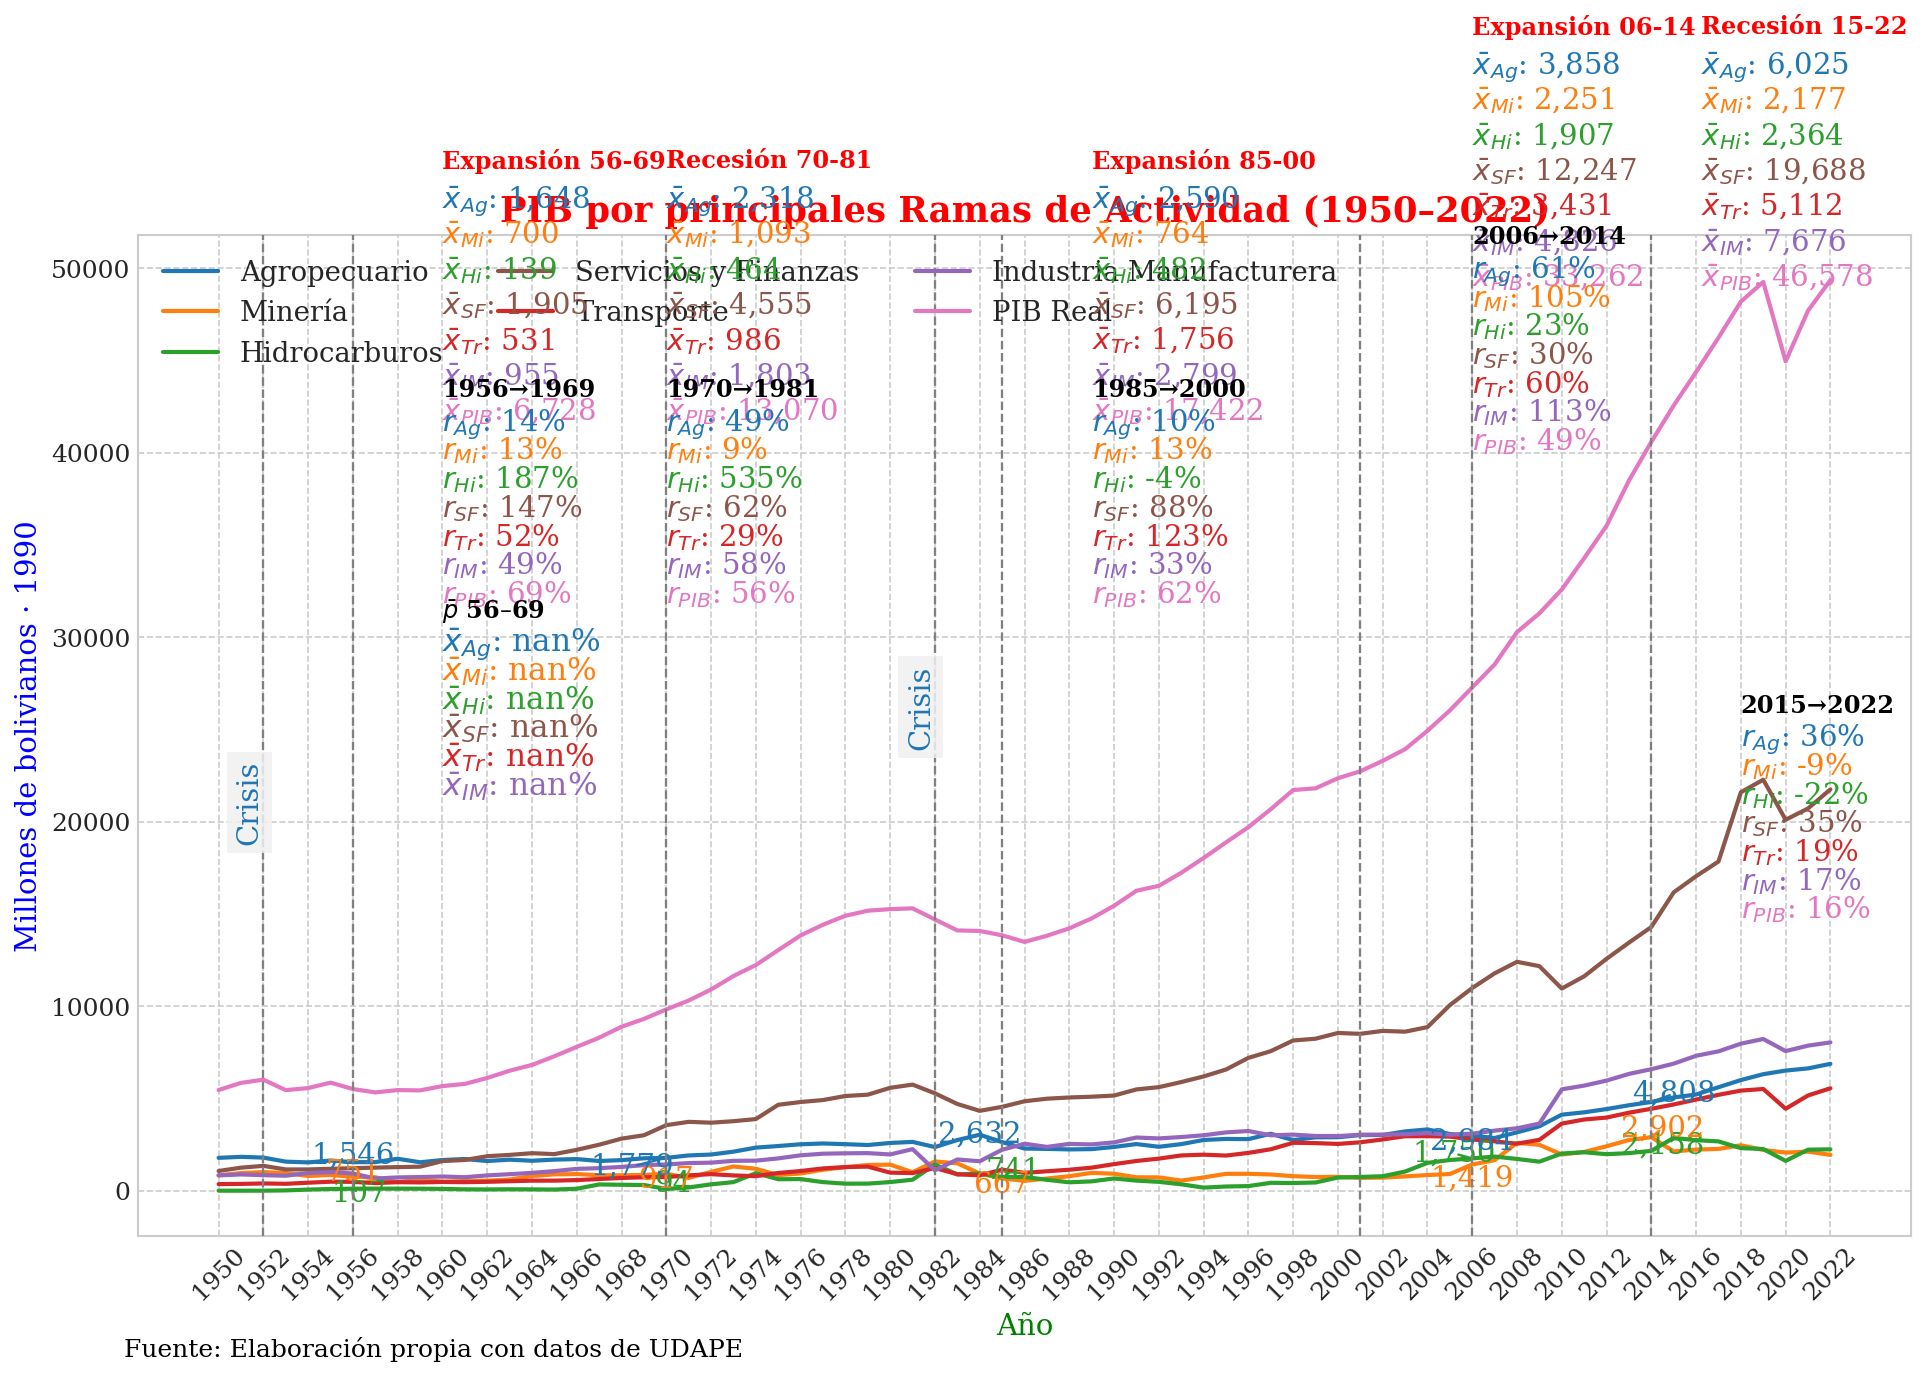

In [3]:
# Estadísticas de ciclos
annot_years=adjust_annot_years(df,annot_years)
CYCLES=adjust_cycles(df,CYCLES)
cycle_stats = {
    name: df.loc[period, cols_componentes].mean().to_dict()
    for name, period in CYCLES.items()
}
periodos=adjust_periods(df,periodos_tasas)

# ── Offsets ──────────────────────────────────────────────────────────
# Desplazamientos de anotaciones por rama y año (anot_years)
# Anotaciones de valores por serie y año (primer gráfico “con crisis”)
annotation_offsets = {
    "agropecuario": {
        1952: (0, 300), 1956: (0, 350), 1970: (-1.5, -450),
        1982: (0, -300), 1985: (-1.0, 400), 2001: (0, -200),
        2006: (0, -300), 2014: (1.0, 450), 2023: (0, -500),
    },
    "mineria": {
        1952: (0, 200), 1956: (0, 250), 1970: (0, -320),
        1982: (0.5, -400), 1985: (0, -350), 2001: (0, -300),
        2006: (0, -750), 2014: (0.5, 500), 2023: (0, -400),
    },
    "petroleo": {
        1952: (0, -200), 1956: (0.3, -250), 1970: (0.3, 300),
        1982: (0, -300), 1985: (0.5, 350), 2001: (-0.5, 250),
        2006: (-0.8, 270), 2014: (0.5, 300), 2023: (0, 200),
    },
    "comercio_finanzas": {
        1952: (0, -250), 1956: (1.5, -300), 1970: (1.5, 500),
        1982: (0, 300), 1985: (1.0, 550), 2001: (-0.7, 400),
        2006: (-0.8, 400), 2014: (1.2, 600), 2023: (0, 200),
    },
}

# Hitos verticales (solo los años definidos en hitos_v)
hitos_offset = {
    1952: 0.45, 1956: 0.50, 1970: 0.50,
    1982: 0.55, 1985: 0.48, 2001: 0.60,
    2006: 0.62, 2014: 0.50,
}

# Posición de los recuadros de medias por ciclo (claves según CYCLES)
text_offsets = {
    "Expansión 56-69": (1960, 1.09),
    "Recesión 70-81": (1970, 1.09),
    "Expansión 85-00": (1989, 1.09),
    "Expansión 06-14": (2006, 1.23),
    "Recesión 15-22": (2016.2, 1.23),
}
# Desplazamientos de tasa de crecimiento por periodo (claves según periodos_tasas)
period_offsets = {
    "1956-1969": (1960, 0.85),
    "1970-1981": (1970, 0.85),
    "1985-2000": (1989, 0.85),
    "2006-2014": (2006, 1.01),
    "2015-2022": (2018, 0.52),
}

# Desplazamientos de cajas de participación por periodo (claves según periodos_tasas)
participation_offsets = {
    "1956-1969": (1960, 0.62),
    "1970-1981": (1970, 0.62),
    "1985-2000": (1989, 0.62),
    "2006-2014": (2005, 0.78),
    "2015-2022": (2018, 0.14),
}

#grafica
fig, ax = init_base_plot(
    df=df,
    series=componentes,
    colors=custom_colors,
    title=f"PIB por principales Ramas de Actividad ({df.index[0]}–{df.index[-1]})",
    xlabel="Año",
    ylabel="Millones de bolivianos · 1990",
    source_text="Fuente: Elaboración propia con datos de UDAPE"
)

# Líneas de hitos y anotaciones
add_hitos(ax, df.index, hitos_v, hitos_offset)
add_year_value_annotations(
    ax, df, annot_years, cols_componentes,
    annotation_offsets, custom_colors
)

add_cycle_means_multi(
    ax, cycle_stats, text_offsets,
    abbr, custom_colors, line_spacing=line_spacing
)

# Tasas de crecimiento por periodo
add_period_growth_annotations_multi(
    ax, df, periodos, cols_componentes,
    period_offsets, custom_colors, abbr
)

# Cuadros de participación por ciclo
add_participation_cycle_boxes(
    ax, df, periodos, cols_componentes,
    "pib_real", participation_offsets,
    abbr, custom_colors
)
ax.set_ylim(-800,12500)
#plt.savefig(os.path.join(output_dir, "pib_rama_de_actividad_con_crisis.png"))
plt.show()